### 1. Difficulty determination
In this notebook, we will train a Squeeze Excitation ResNet on sudokus with the number of empty cells distributed uniformly between [1, 64],
and then use this network to determine the "natural difficulty" of sudokus by calculating the p loss as a function of the number of empty cells. 
This is a rough approximation for many reasons, some of which include:
1. We are only analyzing p loss, not v loss.
2. The "natural difficulty" of sudokus will be different for each network architecture.

### Initialization

In [1]:
!pip install --upgrade --quiet git+https://github.com/dtonderski/DeepSudoku

In [2]:
!pip show deepsudoku

Name: deepsudoku
Version: 0.7.5.3
Summary: Solving Sudokus using a Neural Network assisted Monte-Carlo approach.
Home-page: https://github.com/dtonderski/DeepSudoku
Author: davton
Author-email: dtonderski@gmail.com
License: GNU GPLv3
Location: /usr/local/lib/python3.9/dist-packages
Requires: einops, numpy, py-sudoku, torch
Required-by: 


### Data
Starting from solved sudoku, first split the data into train/val/test, then load it into memory

In [ ]:
from deepsudoku.utils import data_utils

In [ ]:
data_utils.split_data()

In [ ]:
train_sudokus_raw, val_sudokus_raw, test_sudokus_raw = data_utils.load_data()

In [ ]:
val_sudokus = data_utils.make_moves(val_sudokus_raw, n_moves_distribution=data_utils.uniform_possible_moves_distribution)

### Network
Load and configure the neural network

In [7]:
from deepsudoku.dsnn import se_resnet, loss, evaluation
from deepsudoku.utils import network_utils
import torch
import random
from collections import defaultdict
import datetime
import os
import numpy as np

In [8]:
network = se_resnet.SeResNet(blocks = 10, filters = 128, se_channels = 32, dropout = 0.2).cuda()
optimizer = torch.optim.Adam(network.parameters())
loss_fn = loss.loss

### Training

In [9]:
phase_augment = {'train': True, 'val': False}
batch_size = 2048
epochs = 1000

In [10]:
best_model_path = f'../models/difficulty/best.pth'
if os.path.exists(best_model_path):
    print("Loading model")
    checkpoint = torch.load(best_model_path)
    network.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    losses = checkpoint['losses']
    cat_accs = checkpoint['cat_accs']
else:
    losses = defaultdict(list)
    cat_accs = defaultdict(list)
    
starting_epoch = len(losses['val'])
best_loss = np.Inf if len(losses['val']) == 0 else losses['val'][-1]

Loading model


In [11]:
train = False

if train:
    for epoch in range(starting_epoch, epochs):
        train_sudokus = data_utils.make_moves(train_sudokus_raw, n_moves_distribution=data_utils.uniform_possible_moves_distribution)
        for phase in ['train' ,'val']:

            augment = phase_augment[phase]

            if phase == 'train':
                sudokus = train_sudokus
                random.shuffle(sudokus)
                network.train()
            else:
                sudokus = val_sudokus
                network.eval()

            batch_losses = []
            batch_cat_accs = []
            for i in range(0, len(sudokus), batch_size):
                batch_sudokus = sudokus[i:i+batch_size]

                x_np, y_np = data_utils.generate_numpy_batch(batch_sudokus, augment = augment)
                x, y = network_utils.numpy_batch_to_pytorch(x_np, y_np, 'cuda')
                y_pred = network(x)

                v_loss_mask = torch.zeros(y[1].shape).cuda()
                batch_p_loss, batch_v_loss = loss_fn(x, y_pred, y, mask = v_loss_mask)    
                batch_loss = batch_v_loss + batch_p_loss
                batch_cat_acc = evaluation.categorical_accuracy(x, y, y_pred)

                batch_losses.append(batch_loss.item())
                batch_cat_accs.append(batch_cat_acc)

                if phase == 'train':
                    optimizer.zero_grad()
                    batch_loss.backward()
                    torch.nn.utils.clip_grad_norm_(network.parameters(), 1)
                    optimizer.step()

                print(f"Phase {phase}, batch {min(i+batch_size, len(sudokus))}/{len(sudokus)}, {batch_p_loss.item()=:.4f}, {batch_cat_acc=:.4f}", end = "\r")

            losses[phase].append(sum(batch_losses)/len(batch_losses))
            cat_accs[phase].append(sum(batch_cat_accs)/len(batch_cat_accs))

        if losses['val'][-1] < best_loss:
            best_loss = losses['val'][-1]
            torch.save({
                'model_state_dict': network.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'cat_accs': cat_accs,
                'losses': losses,
                }, f'{best_model_path}')


        print(f'Epoch {epoch}, loss = {losses["val"][-1]:.4f}, acc = {cat_accs["val"][-1]:.4f}, time = {datetime.datetime.now()}.                                       ')

### Plotting
Plot the losses to see if overfitting is experienced

In [12]:
from matplotlib import pyplot as plt

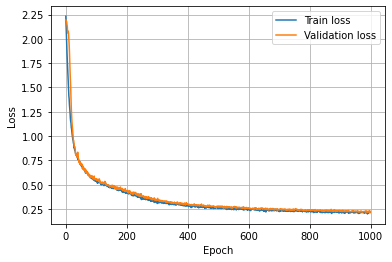

In [13]:
plt.plot(losses['train'])
plt.plot(losses['val'])
plt.legend(['Train loss', 'Validation loss'])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [14]:
test_sudokus = data_utils.make_moves(test_sudokus_raw, n_moves_distribution=data_utils.uniform_possible_moves_distribution)

In [15]:
x_np, y_np = data_utils.generate_numpy_batch(test_sudokus, augment = False)
x, y = network_utils.numpy_batch_to_pytorch(x_np, y_np, 'cuda')
y_pred = network(x)

In [16]:
v_loss_mask = torch.zeros(y[1].shape).cuda()
loss, _ = loss_fn(x, y_pred, y, mask = v_loss_mask)    

In [17]:
print(f"Test loss is {loss:.4f}. Validation loss is {losses['val'][-1]:.4f}. Train loss is {losses['train'][-1]:.4f}.")

Test loss is 0.2115. Validation loss is 0.2182. Train loss is 0.2144.


### Difficulty calculation
As we can see, we have no overfitting, so we can now determine the difficulty. We will be using test and validation sudokus.

In [18]:
difficulty_sudokus = data_utils.make_moves(test_sudokus_raw+val_sudokus_raw, n_moves_distribution=data_utils.uniform_possible_moves_distribution)

In [19]:
x_np, y_np = data_utils.generate_numpy_batch(difficulty_sudokus, augment = False)
x_difficulty, y_difficulty = network_utils.numpy_batch_to_pytorch(x_np, y_np, 'cuda')
y_pred_difficulty = network(x_difficulty)

In [20]:
loss_by_empty_cells = defaultdict(list)


for i in range(x_difficulty.shape[0]):
    x      = x_difficulty[i:i+1]
    y      = (y_difficulty[0][i:i+1],      y_difficulty[1][i:i+1])
    y_pred = (y_pred_difficulty[0][i:i+1], y_pred_difficulty[1][i:i+1])
    
    empty_cells = int((x == 0).sum().cpu())
    
    loss, _ = loss_fn(x, y_pred, y)
    loss_by_empty_cells[empty_cells].append(loss.detach().cpu().item())

In [21]:
loss_by_empty_cells_avgd = {k: sum(v)/len(v) for k, v in loss_by_empty_cells.items()}

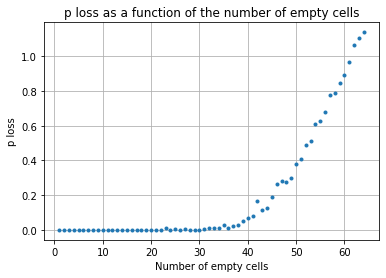

In [22]:
plt.plot(loss_by_empty_cells_avgd.keys(), loss_by_empty_cells_avgd.values(), '.')
plt.grid()
plt.xlabel('Number of empty cells')
plt.ylabel('p loss')
plt.title('p loss as a function of the number of empty cells')
plt.show()


We don't have any data on how "difficult" a zero-empty-cells sudoku is, so extend by assuming it's the same as the one-empty-cell sudoku.


In [28]:
difficulty = [x[1] for x in sorted(loss_by_empty_cells_avgd.items())]
difficulty = [difficulty[0]] + difficulty
difficulty = [x / difficulty[-1] for x in difficulty]

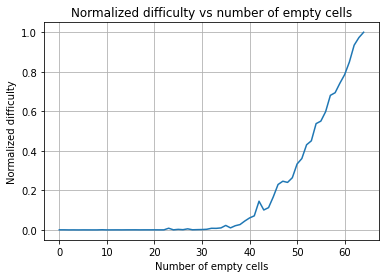

In [29]:
plt.plot(difficulty)
plt.title("Normalized difficulty vs number of empty cells")
plt.xlabel('Number of empty cells')
plt.ylabel('Normalized difficulty')
plt.grid()
plt.show()

Save the normalized and extended difficulty as a numpy array.

In [30]:
data_utils.save_difficulty(difficulty)

Load to make sure everything works fine

In [31]:
difficulty_loaded = data_utils.load_difficulty()
assert np.all(difficulty_loaded == difficulty)